# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1MtGkaegLqPdIs6R4cVQlUEkV9Mr7sLZH/view?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

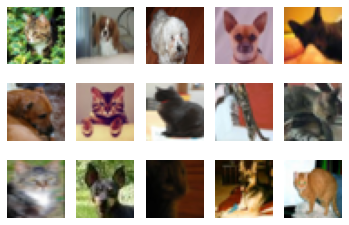

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
print("Total training examples:", len(train_loader))
print("Total validation examples:", len(val_loader))
print("Total test examples:", len(test_loader))

Total training examples: 8000
Total validation examples: 2000
Total test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [6]:
# The validation set is used to tune the hyperparameters of the model after 
# training the weights (learnable parameters). The performance of the model
# on the training set error is a poor measure, since the model was trained
# using the data. The model's predictions on unobserved data is a much more
# relevant measure; the training set does not qualify as "unobserved" data.
# The performance of the model will always be great against the training data. 

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [10]:
print("Total number of parameters in small_net:", sum([
  torch.numel(param)

  for param in small_net.parameters()
]))

print("Total number of parameters in large_net:", sum([
  torch.numel(param)

  for param in large_net.parameters()
]))

Total number of parameters in small_net: 386
Total number of parameters in large_net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [11]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [12]:
# The default parameters are
# - batch_size = 64
# - learning_rate = 0.01
# - num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [13]:
# The four files that are written to the disk are
# - model_small_bs64_lr0.01_epoch4_train_err.csv (training error of each epoch)
# - model_small_bs64_lr0.01_epoch4_train_loss.csv (training loss of each epoch)
# - model_small_bs64_lr0.01_epoch4_val_error.csv (testing error of each epoch)
# - model_small_bs64_lr0.01_epoch4_val_loss.csv (testing loss of each epoch)

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [14]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
train_net(small_net)
train_net(large_net)

# The small network took 102.63 seconds while the large network took 111.40 
# seconds. This makes sense as the larger network has 9,319 more parameters to
# train, and would take longer to train. 

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423625, Train loss: 0.6725465445518494 |Validation err: 0.386, Validation loss: 0.6587053779512644
Epoch 2: Train err: 0.37575, Train loss: 0.650308669090271 |Validation err: 0.387, Validation loss: 0.6656124647706747
Epoch 3: Train err: 0.360375, Train loss: 0.6403244805335998 |Validation err: 0.3475, Validation loss: 0.6315254252403975
Epoch 4: Train err: 0.34875, Train loss: 0.6274946994781494 |Validation err: 0.345, Validation loss: 0.6260619889944792
Epoch 5: Train err: 0.34525, Train loss: 0.6176664690971374 |Validation err: 0.341, Validation loss: 0.619855560362339
Epoch 6: Train err: 0.328875, Train loss: 0.6052448828220367 |Validation err: 0.331, Validation loss: 0.612820478156209
Epoch 7: Train err: 0.321875, Train loss: 0.5986335027217865 |Validation err: 0.3275, Validation loss: 0.6104573626071215
Epoch 8: Train err: 0.3135, Train loss: 0.5914606981277466 |Validation err: 0.334

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

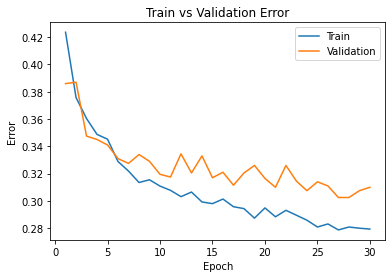

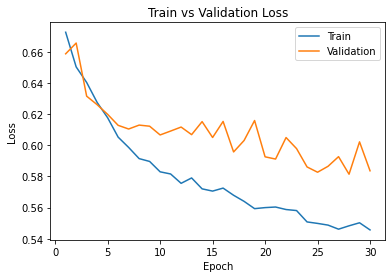

In [16]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_model_path)

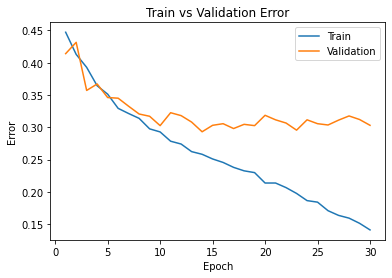

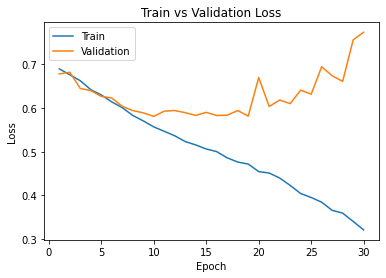

In [17]:
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [18]:
# The training curve for small_net fluctuates a lot more than the training curve
# for large_net. The large_net network begins with a far greater training error
# and loss than the small_net, due to the amount of initial parameters, but
# steadily converges to a better performance than the small_net. The large_net
# training curve doesn't fluctuate much. There is also not a lot of overall 
# decrease in the small_net training curve.

# The small_net training curve is an example of underfitting. The training and
# validation loss does not change by much as the training continues. The 
# difference initial beteween the beginning and end loss/error of both curves 
# are not significant. The large_net training curve is an example of 
# overfitting, since the validation error and loss curves back upwards around
# the 25th epoch, even though the training error and loss decreases. This 
# indicates that the model is not properly generalizing to unobserved data.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

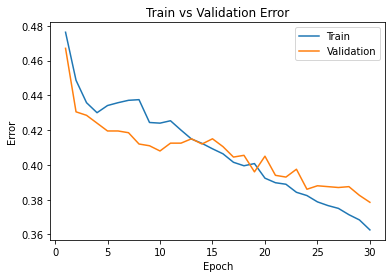

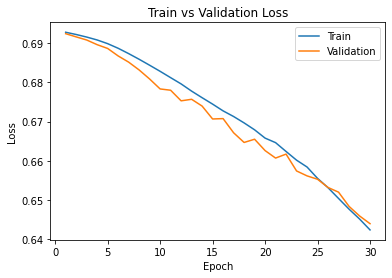

In [19]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.001)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

# The training took a shorter amount of time, but not enough to note a 
# significant change. Learning rate should, theoretically, not effect the speed
# of training, but rather the amount in which the weights are effected by the
# loss at each epoch. 

# The lowered learning rate slowed the speed of the convergence so much that the 
# final training and validation loss/error that the model achieves is far from 
# the optimum achieved with the learning rate of 0.01. The curve, however, is 
# steady and consistent. Although the nature of the curve is an example of good 
# training i.e. the training and validation loss/error decreasing consistently, 
# the changes are too slow and small each epoch for the final model to have good 
# predictions.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

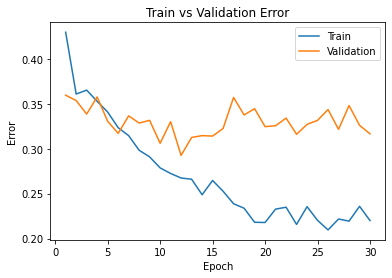

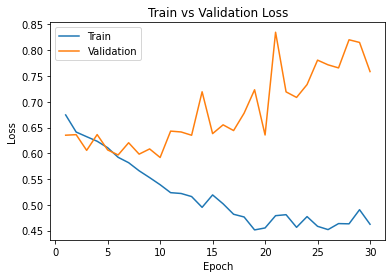

In [20]:
large_net = LargeNet()

train_net(large_net, learning_rate=0.1)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

# Just like the previous training, raising the learning rate should not effect
# the training time by a significant amount, since it'll only raise the amount
# of change to the weights at each epoch. The training time did decrease in 
# comparison to the training time of learning rate 0.01, but not by a 
# significant amount. 

# The increased learning rate caused the training curves to be a lot more 
# erratic. The training finishes with a lower training loss/error than the 
# previous model, but it sacrificed model performance against the validation 
# set. Neither the validation loss nor error indicates any significant decreases 
# or improvements on performance.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

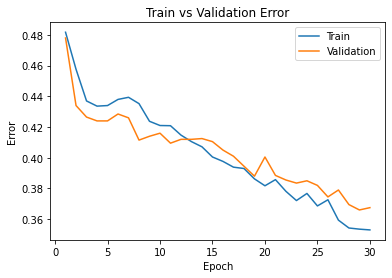

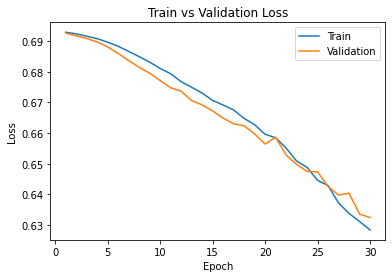

In [21]:
large_net = LargeNet()

train_net(large_net, batch_size=512)
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

# The model takes a lot less time to train, since each batch size is larger and
# requires less iterations to complete 1 epoch. 

# Increasing the batch size allows the descent to be a lot smoother, as the 
# gradient being calculated at each iteration is more generalized. Due to the
# larger batch size, however, there are fewer iterations and fewer updates to
# the weight parameters, causing the overall training to be "slower". With a 
# larger batch size, the training requires more epochs to achieve an optimum
# that might've been achieved with a smaller batch size like 64. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

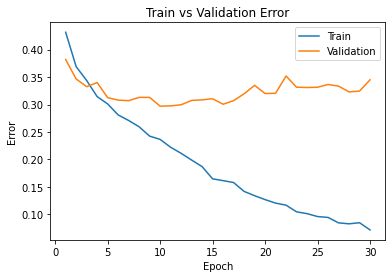

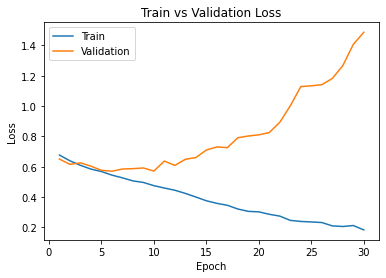

In [22]:
large_net = LargeNet()

train_net(large_net, batch_size=16)
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

# The model takes a lot more time to train, since each batch size is smaller and
# requires more iterations to complete 1 epoch. 

# Due to the smaller batch size, there are far more iterations and updates to
# the weight parameters, causing the overall training to be "faster". With a 
# smaller batch size, the model becomes overfit to the training data. This is
# reflected in the validation curve, as the validation loss increases as 
# training loss decreases.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [23]:
# I think using the large network, smaller batch size, and slower learning rate 
# would help improve the validation accuracy. The smaller batch size would 
# introduce noise and help converge on a global optimum, instead of local
# minima. The slower learning rate would help converge more carefully, as
# the noise from the smaller batch size might cause the training to be too
# too erratic. Working with the larger network also allows more diverse sets of
# parameters to be trained.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454875, Train loss: 0.6919687836170196 |Validation err: 0.4335, Validation loss: 0.6896940703392029
Epoch 2: Train err: 0.441875, Train loss: 0.6881972500085831 |Validation err: 0.4155, Validation loss: 0.6840243172645569
Epoch 3: Train err: 0.425, Train loss: 0.6826031126976013 |Validation err: 0.4065, Validation loss: 0.6759178109169006
Epoch 4: Train err: 0.413375, Train loss: 0.676551971077919 |Validation err: 0.411, Validation loss: 0.6703446621894836
Epoch 5: Train err: 0.403, Train loss: 0.6706955729722976 |Validation err: 0.405, Validation loss: 0.6636172285079956
Epoch 6: Train err: 0.388375, Train loss: 0.6634951171875 |Validation err: 0.388, Validation loss: 0.6577684187889099
Epoch 7: Train err: 0.38325, Train loss: 0.6566604214906693 |Validation err: 0.387, Validation loss: 0.6490317993164062
Epoch 8: Train err: 0.372625, Train loss: 0.6456744936108589 |Validation err: 0.3795,

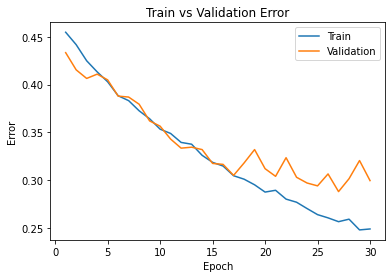

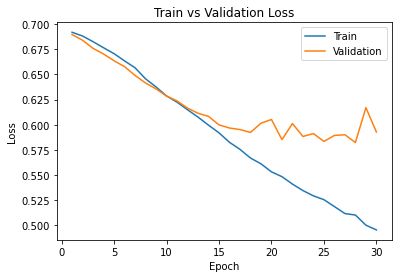

In [24]:
large_net = LargeNet()

train_net(large_net, batch_size=16, learning_rate=0.001)
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [25]:
# I think using the large network, larger batch size, and faster learning rate 
# could be another way to improve validation accuracy. This is the other extreme
# from the previous set of hyperparameters, by introducing noise through the
# learning rate, and trying to counterbalance with the larger batch size.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.460375, Train loss: 0.692389577627182 |Validation err: 0.428, Validation loss: 0.6908226907253265
Epoch 2: Train err: 0.450875, Train loss: 0.6895152404904366 |Validation err: 0.4225, Validation loss: 0.6841378808021545
Epoch 3: Train err: 0.430125, Train loss: 0.6831201873719692 |Validation err: 0.4165, Validation loss: 0.6750585436820984
Epoch 4: Train err: 0.41775, Train loss: 0.6756713278591633 |Validation err: 0.4075, Validation loss: 0.6670383214950562
Epoch 5: Train err: 0.401625, Train loss: 0.667489554733038 |Validation err: 0.393, Validation loss: 0.6609293520450592
Epoch 6: Train err: 0.385125, Train loss: 0.6585139334201813 |Validation err: 0.3795, Validation loss: 0.6547118723392487
Epoch 7: Train err: 0.372125, Train loss: 0.6462636440992355 |Validation err: 0.377, Validation loss: 0.6396276503801346
Epoch 8: Train err: 0.36675, Train loss: 0.6378163807094097 |Validation err:

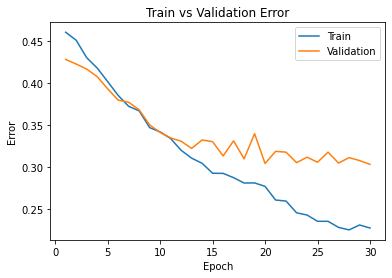

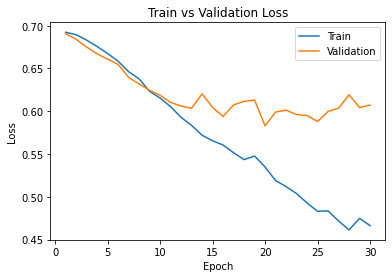

In [26]:
large_net = LargeNet()

train_net(large_net, batch_size=512, learning_rate=0.05)
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.05, epoch=29)
plot_training_curve(large_model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [27]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.05, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [28]:
# This particular model had the best training and validation curve. The two
# curves decrease consistently as there are more epochs i.e. not too much
# erratic descent, no upwards increase (not overfitting), and closeness of the
# two curves (not underfitting). 

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [29]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, criterion)

print("Test Classification Error:", err)
print("Test Classification Loss:", loss)

Files already downloaded and verified
Files already downloaded and verified
Test Classification Error: 0.299
Test Classification Loss: 0.584050253033638


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [30]:
# The test classification error is in fact lower than the validation error, but 
# for the sake of the question I will assume otherwise.

# The validation set was used to tune the hyperparameters, and thus, in some
# sort of way, the model was fit to the validation set. As a result, the 
# validation set is not considered "unobserved" data anymore, and the validation
# error was reduced. The testing or holdout set is now the true "unobserved"
# data, as no part of the model has been tuned with respect to the data. The
# model's performance against unobserved data is should theoretically be poorer
# than its performance against observed data that it has been tuned for.  

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [31]:
# The test data should be used only after the model has been completely trained
# and tuned. This data is considered "unobserved", and should be presented to
# the model as little as possible, to avoid the model being biased towards the
# data to any degree.

### Part (f) - 5pt

How does your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images? You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.438375, Train loss: 0.6775508187711239 |Validation err: 0.4015, Validation loss: 0.6573085337877274
Epoch 2: Train err: 0.389875, Train loss: 0.6524141989648342 |Validation err: 0.3925, Validation loss: 0.652656763792038
Epoch 3: Train err: 0.368375, Train loss: 0.639910165220499 |Validation err: 0.3905, Validation loss: 0.6505168825387955
Epoch 4: Train err: 0.35475, Train loss: 0.6290779784321785 |Validation err: 0.4035, Validation loss: 0.6553575843572617
Epoch 5: Train err: 0.34875, Train loss: 0.619865033775568 |Validation err: 0.384, Validation loss: 0.6446329951286316
Epoch 6: Train err: 0.332875, Train loss: 0.6069212555885315 |Validation err: 0.3795, Validation loss: 0.6492351591587067
Epoch 7: Train err: 0.320375, Train loss: 0.5965600870549679 |Validation err: 0.3795, Validation loss: 0.6553872674703598
Epoch 8: Train err: 0.30975, Train loss: 0.5847571343183517 |Validation err:

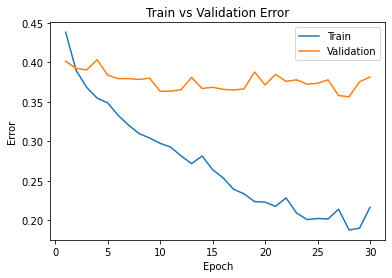

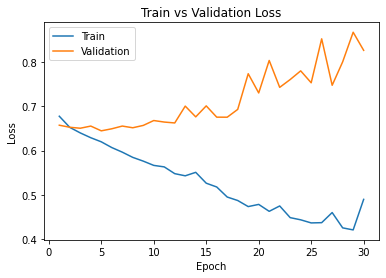

Files already downloaded and verified
Files already downloaded and verified
Test Classification Error: 0.38
Test Classification Loss: 0.8307395875453949


In [32]:
torch.manual_seed(1) # set the random seed

class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(3 * 32 * 32, 20)
        self.layer2 = nn.Linear(20, 1)

    def forward(self, x):
        flattened = x.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

pigeon = Pigeon()

train_net(pigeon, batch_size=512, learning_rate=0.05, num_epochs=30)
ann_model_path = get_model_name("pigeon", batch_size=512, learning_rate=0.05, epoch=29)
plot_training_curve(ann_model_path)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(pigeon, test_loader, criterion)

print("Test Classification Error:", err)
print("Test Classification Loss:", loss)

# The 2-layer ANN unfortunately could not predict as well as the CNN model. The
# best test accuracy the ANN model could achieve was lower compared to the CNN
# model. This is due to the fact that CNN models use convolution, an image 
# filtering technique to help recognize important features in images that
# normal ANN model's can't pick out. Thus, for specific image prediction 
# problems such as this, a CNN model would work better than an ANN model. 